# Evaluation Board

In [2]:
%matplotlib inline
import os, sys
import glob, json
import shutil

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from birl.utilities.data_io import update_path
from birl.utilities.evaluate import compute_ranking
from birl.utilities.visualisation import RadarChart
from bm_ANHIR.generate_regist_pairs import VAL_STATUS_TRAIN, VAL_STATUS_TEST

This notebook serves for computing extended statistics (e.g. metrics inliding ranks) and visualie some more statistics.

In [3]:
PATH_SUBMISSIONS = os.path.join(update_path('bm_ANHIR'), 'submissions')
PATH_TEMP = os.path.abspath(os.path.expanduser('~/Desktop/ANHIR_submissions'))
PATH_DATASET = os.path.join(update_path('bm_ANHIR'), 'dataset_ANHIR')
PATH_TABLE = os.path.join(PATH_DATASET, 'dataset_medium.csv')
PATH_LNDS_PROVIDED = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_LNDS_COMPLATE = os.path.join(PATH_DATASET, 'landmarks_all')
PATH_COMP_BM = os.path.join(PATH_DATASET, 'computer-performances_cmpgrid-71.json')

## Parse and load submissions

All submissions are expected to be as a zip archives in single folder. The archive name is the author name.

In [4]:
# Find all archives and unzip them to the same folder.
archive_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.zip')))
submission_dirs = []

for path_zip in tqdm.tqdm(archive_paths, desc='unzipping'):
    sub = os.path.join(PATH_TEMP, os.path.splitext(os.path.basename(path_zip))[0])
    os.system('unzip %s -d %s' % (path_zip, sub))
    sub_ins = glob.glob(os.path.join(sub, '*'))
    if len(sub_ins) == 1:  # if the zip subfolder contain only one folder move it up
        [shutil.move(p, sub) for p in glob.glob(os.path.join(sub_ins[0], '*'))]
    submission_dirs.append(sub)

unzipping: 100%|██████████| 8/8 [00:00<00:00, 28.79it/s]


Parse submissions and compute the final metrics. This can be computed just once.

In [ ]:
import bm_ANHIR.evaluate_submission

for path_sub in tqdm.tqdm(submission_dirs, desc='evaluation'):
    path_json = bm_ANHIR.evaluate_submission.main(
        path_experiment=path_sub,
        path_cover=PATH_TABLE,
        path_dataset=PATH_LNDS_PROVIDED,
        path_reference=PATH_LNDS_COMPLATE,
        path_comp_bm=PATH_COMP_BM,
        path_output=path_sub,
        min_landmarks=1., details=True)
    shutil.copy(os.path.join(path_sub, 'metrics.json'),
                os.path.join(PATH_SUBMISSIONS, os.path.basename(path_sub) + '.json'))

Load parsed measures from each submission/experiment.

In [5]:
submission_paths = sorted(glob.glob(os.path.join(PATH_SUBMISSIONS, '*.json')))
submissions = {}
for path_sub in tqdm.tqdm(submission_paths, desc='loading'):
    with open(path_sub, 'r') as fp:
        metrics = json.load(fp)
    submissions[os.path.splitext(os.path.basename(path_sub))[0]] = metrics

print ('Users: %r' % submissions.keys())

loading: 100%|██████████| 8/8 [00:00<00:00, 89.85it/s]

Users: dict_keys(['HistoReg', 'Mohammed', 'delamoer', 'lMW', 'masi', 'nick.weiss', 'pszma2', 'zhaoshuaibit'])


In [6]:
# split the particular fields inside the measured items
users = list(submissions.keys())
print ('Fields: %r' % submissions[users[0]].keys())
user_aggreg = {u: submissions[u]['aggregates'] for u in users}
user_computer = {u: submissions[u]['computer'] for u in users}
user_cases = {u: submissions[u]['cases'] for u in users}
print ('required-landmarks: %r' % [submissions[u]['required-landmarks'] for u in users])

Fields: dict_keys(['aggregates', 'cases', 'computer', 'submission-time', 'required-landmarks'])
required-landmarks: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Compute ranked measures

Extend the aggregated statistic by Rank measures such as compute ranking over all cases for each selected field and average it

In [7]:
for robust in [True, False]:  # iterate over Robust or all cases
    for field, field_agg in [('rTRE-Median', 'Average-Rank-Median-rTRE'),
                             ('rTRE-Max', 'Average-Rank-Max-rTRE')]:
        user_cases = compute_ranking(user_cases, field)
        field_agg = field_agg + '-Robust' if robust else field_agg
        for user in users:
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field + '_rank'] for cs in user_cases[user]
                    if (robust and user_cases[user][cs]['Robustness']) or (not robust)]
            user_aggreg[user][field_agg] = np.mean(vals)

In [8]:
pd.DataFrame(user_aggreg).T.sort_values('Average-Rank-Median-rTRE')

,Average-Max-rTRE,Average-Max-rTRE-Robust,Average-Max-rTRE_test,Average-Max-rTRE_train,Average-Median-rTRE,Average-Median-rTRE-Robust,Average-Median-rTRE_test,Average-Median-rTRE_train,Average-Norm-Time,Average-Norm-Time-Robust,...,Average-Rank-Max-rTRE-Robust,Average-Rank-Median-rTRE,Average-Rank-Median-rTRE-Robust,Average-Robustness,Average-Robustness_test,Average-Robustness_train,Average-used-landmarks,Median-Average-rTRE,Median-Max-rTRE,Median-Median-rTRE
nick.weiss,0.026069,0.024423,0.025107,0.027120,0.003852,0.002923,0.002870,0.004924,0.145392,0.145501,...,3.002083,1.711019,1.697917,0.997921,1.000000,0.995652,1.025250,0.002889,0.018566,0.001815
lMW,0.037534,0.035033,0.039306,0.035600,0.005397,0.004339,0.005833,0.004922,9.495231,9.453867,...,4.517970,2.569647,2.498943,0.983368,0.976096,0.991304,1.028034,0.003848,0.025837,0.002136
zhaoshuaibit,0.022812,0.022798,0.025426,0.019960,0.003506,0.003501,0.004251,0.002693,6.098517,6.106647,...,3.210417,3.388773,3.385417,0.997921,0.996016,1.000000,1.026104,0.003499,0.017152,0.002625
masi,0.043899,0.030387,0.034639,0.054004,0.012719,0.003934,0.008861,0.016928,7.387142,7.400403,...,3.627451,3.844075,3.262255,0.992701,0.991667,0.994152,1.007034,0.003719,0.023518,0.002535
HistoReg,0.026130,0.026130,0.026584,0.025635,0.004724,0.004724,0.004838,0.004600,4.232554,4.232554,...,3.839917,4.675676,4.675676,1.000000,1.000000,1.000000,1.025198,0.004535,0.020896,0.003478
delamoer,0.027622,0.027284,0.026752,0.028570,0.006415,0.006205,0.006139,0.006717,7.127142,7.155800,...,4.317992,5.681913,5.667364,0.993763,1.000000,0.986957,1.025356,0.005899,0.021648,0.004880
Mohammed,0.085886,0.070253,0.085982,0.085782,0.025846,0.018793,0.028413,0.023044,0.448220,0.453302,...,5.821267,6.523909,6.490950,0.918919,0.928287,0.908696,1.030000,0.010619,0.045230,0.007908
pszma2,0.091337,0.069033,0.093570,0.088900,0.028729,0.018148,0.031994,0.025166,1.488435,1.506194,...,6.892449,7.604990,7.578947,0.908524,0.904382,0.913043,1.031739,0.010342,0.044584,0.007908


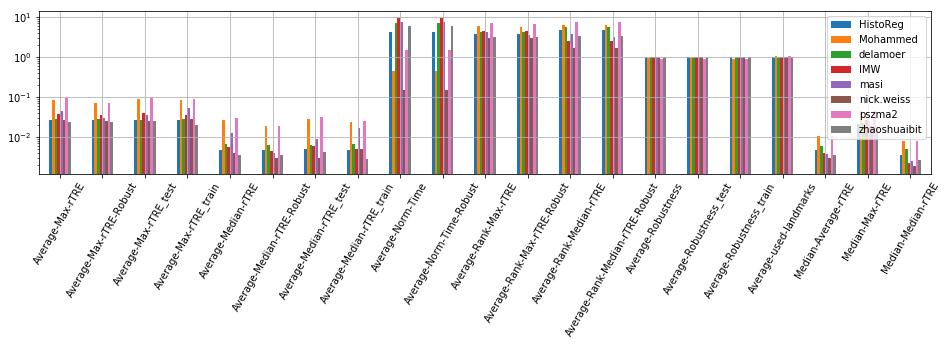

In [9]:
_= pd.DataFrame(user_aggreg).plot.bar(figsize=(16, 3), grid=True, logy=True, rot=60)

## Compare statistic "train" vs "test"

In [10]:
for state in [VAL_STATUS_TRAIN, VAL_STATUS_TEST]:
    for field, field_agg in [('rTRE-Median', 'Average-Median-rTRE'),
                             ('rTRE-Median_rank', 'Average-Rank-Median-rTRE'),
                             ('rTRE-Max', 'Average-Max-rTRE'),
                             ('rTRE-Max_rank', 'Average-Rank-Max-rTRE')]:
        for user in users:
            # chose inly robyst if it is required
            vals = [user_cases[user][cs][field] for cs in user_cases[user]
                    if user_cases[user][cs]['Status'] == state]
            user_aggreg[user][field_agg + '_' + state] = np.nanmean(vals)

In [11]:
df = pd.DataFrame(user_aggreg).T
cols = [col for col in df.columns if any(st in col for st in [VAL_STATUS_TRAIN, VAL_STATUS_TEST])]
df[cols].sort_values('Average-Rank-Median-rTRE_evaluation')

,Average-Max-rTRE_evaluation,Average-Max-rTRE_training,Average-Median-rTRE_evaluation,Average-Median-rTRE_training,Average-Rank-Max-rTRE_evaluation,Average-Rank-Max-rTRE_training,Average-Rank-Median-rTRE_evaluation,Average-Rank-Median-rTRE_training
nick.weiss,0.025107,0.027120,0.002870,0.004924,3.107570,2.908696,1.621514,1.808696
lMW,0.039306,0.035600,0.005833,0.004922,4.418327,4.721739,2.446215,2.704348
masi,0.028788,0.037658,0.005206,0.004582,3.721116,4.621739,3.258964,4.482609
zhaoshuaibit,0.025426,0.019960,0.004251,0.002693,3.482072,2.926087,3.916335,2.813043
HistoReg,0.026584,0.025635,0.004838,0.004600,3.916335,3.756522,4.828685,4.508696
delamoer,0.026752,0.028570,0.006139,0.006717,4.402390,4.269565,5.705179,5.656522
Mohammed,0.085982,0.085782,0.028413,0.023044,5.984064,5.817391,6.617530,6.421739
pszma2,0.093570,0.088900,0.031994,0.025166,6.968127,6.978261,7.605578,7.604348


In [12]:
dfs_cases = []
for usr in users:
    df = pd.DataFrame(user_cases[usr]).T
    df['user'] = usr
    df['case'] = df.index
    dfs_cases.append(df)
df_cases = pd.concat(dfs_cases).reset_index()

for col in df_cases.columns:
    try: df_cases[col] = pd.to_numeric(df_cases[col])
    except Exception: pass
# df_cases.head()

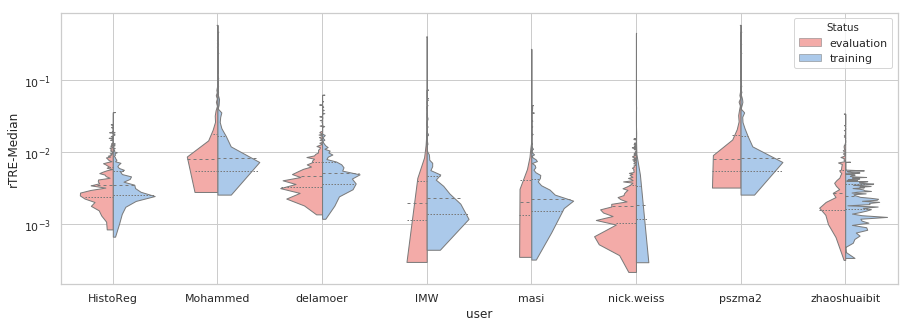

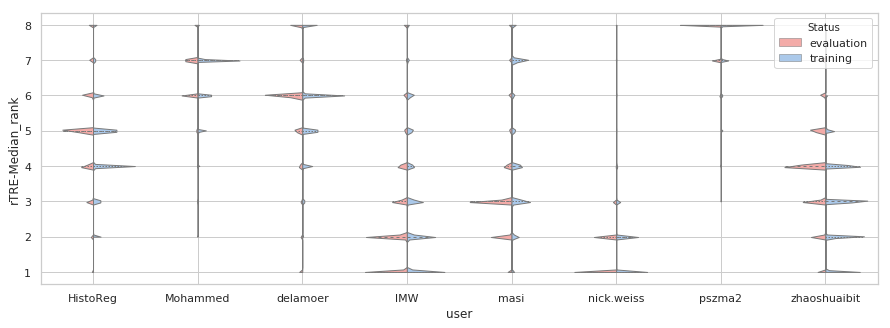

In [13]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
for field, log in [('rTRE-Median', True), ('rTRE-Median_rank', False)]:
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.violinplot(ax=ax, data=df_cases, x='user', hue='Status', y=field,
                   cut=0, split=True, bw=0.02, scale='area', scale_hue=True, inner='quartile',
                   palette={"evaluation": "r", "training": "b"}, linewidth=1.)
    if log:
        ax.set_yscale('log')
    ax.grid(True)

## Visualise global results

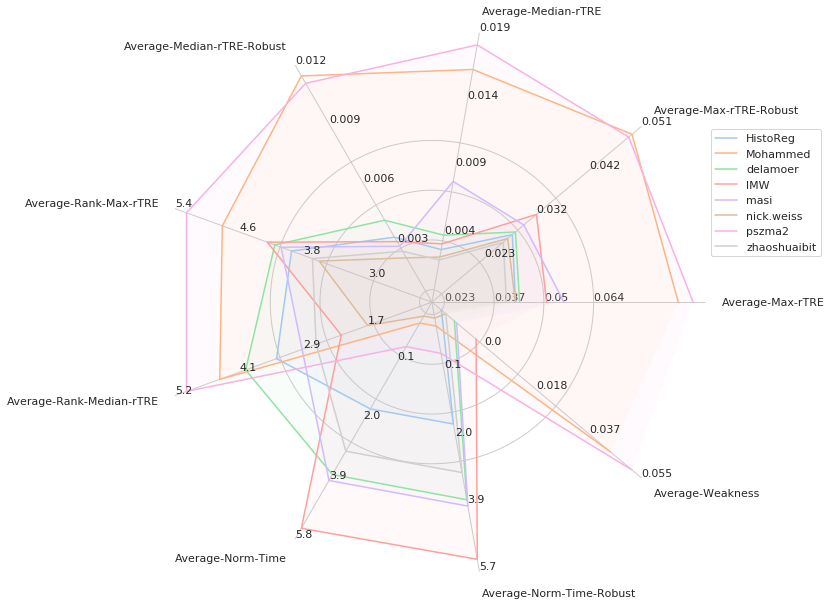

In [14]:
fields = ['Average-Max-rTRE', 'Average-Max-rTRE-Robust',
          'Average-Median-rTRE', 'Average-Median-rTRE-Robust',
          'Average-Rank-Max-rTRE', 'Average-Rank-Median-rTRE',
          'Average-Norm-Time', 'Average-Norm-Time-Robust',
          'Average-Robustness',]
df = pd.DataFrame(user_aggreg).T[fields]
df['Average-Weakness'] = 1 - df['Average-Robustness']
del df['Average-Robustness']

radar = RadarChart(df, fig=plt.figure(figsize=(12, 8)))

## Visualise partial results

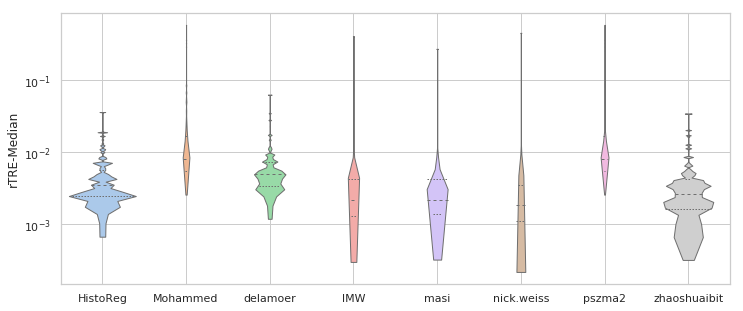

In [17]:
# from plotly.offline import init_notebook_mode, plot, iplot
# import plotly.figure_factory as ff
# init_notebook_mode(connected=True)

for field in ['rTRE-Median']:  # , 'rTRE-Max'
    df = pd.DataFrame({us: {cs: user_cases[us][cs][field] for cs in user_cases[us]} for us in users})
    # fig = ff.create_distplot([df[us].values for us in users], users, bin_size=0.001)
    # iplot(fig, logx=True)
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.violinplot(ax=ax, data=df, split=True, cut=0, bw=.005, inner='quartile', linewidth=1.)
    _ = ax.set_yscale('log'), ax.set_ylabel(field)
    ax.grid(True)
